In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import functools
import numpy as np
import os
import pvtrace
import scintillator_tracer as st


ANGLE = 90
ALL_CUTS_STL = '/home/reed/Documents/research/grimpress/crystal-geometry/notebooks/isosceles_prisms/cut_progression/models/all-cuts-Body.stl'
ALL_CUTS_ESR_SHELL_STL = '/home/reed/Documents/research/grimpress/crystal-geometry/notebooks/isosceles_prisms/cut_progression/models/all-cuts-esr-shell-Body.stl'

In [4]:
def build_all_cuts_world(
    angle: float,
    crystal_kwargs: dict = {},
    esr_shell_kwargs: dict = {},
    optical_pad_kwargs: dict = {},
    sipm_kwargs: dict = {},
    world: pvtrace.Node = None
) -> dict:
    """
    Angle is in degrees.
    """

    if world is None:
        world = st.definitions.generate_world()
    
    SCALING = np.cos(np.radians(45))
    DEFAULT_KWARGS = dict(
        crystal = dict(
            stl_file=ALL_CUTS_STL.format(angle=angle),
            scaling=0.1,
            world=world
        ),
        esr_shell = dict(
            stl_file=ALL_CUTS_ESR_SHELL_STL.format(angle=angle),
            scaling=0.1,
            world=world
        ),
        optical_pad = dict(
            world=world,
            size=(0.4/SCALING, 6.6, 0.01)
        ),
        sipm = dict(
            world=world,
            size=(0.6, 6.6, 0.05)
        )
    )

    crystal = st.definitions.generate_crystal(**{**DEFAULT_KWARGS['crystal'], **crystal_kwargs})
    esr_shell = st.definitions.generate_esr_shell(**{**DEFAULT_KWARGS['esr_shell'], **esr_shell_kwargs})
    optical_pad = st.definitions.generate_optical_pad(**{**DEFAULT_KWARGS['optical_pad'], **optical_pad_kwargs})
    sipm = st.definitions.generate_sipm(**{**DEFAULT_KWARGS['sipm'], **sipm_kwargs})
    
    h = (0.01+0.0001) / np.sin(np.radians(angle/2))
    st.worlds.basic_stack(crystal, esr_shell, optical_pad, sipm, h)

    crystal_width = st.geometry_helpers.max_physical_value(crystal, 'x') - \
        st.geometry_helpers.min_physical_value(crystal, 'x')
    pad_thickness = st.geometry_helpers.max_physical_value(optical_pad, 'z') - \
        st.geometry_helpers.min_physical_value(optical_pad, 'z')
    sipm_thickness = st.geometry_helpers.max_physical_value(sipm, 'z') - \
        st.geometry_helpers.min_physical_value(sipm, 'z')
    angle = 45
    h = crystal_width / np.tan( np.radians(90-angle) )
    movex = -pad_thickness/2 * np.sin( np.radians(angle) )
    movez = -( h/2 + pad_thickness/2 )

    optical_pad.translate((0, 0, movez))
    optical_pad.rotate(np.radians(angle), (0, 1, 0))
    optical_pad.translate((-movex, 0, pad_thickness/2 * np.cos(np.radians(angle))))

    movex = -(sipm_thickness/2+pad_thickness) * np.sin(np.radians(angle))
    movez = -(h/2 + pad_thickness + sipm_thickness/2)
    sipm.translate((0, 0, movez))
    sipm.rotate(np.radians(angle), (0, 1, 0))
    sipm.translate((-movex, 0, (sipm_thickness/2+pad_thickness) * np.cos(np.radians(angle))))

    nodes = dict(
        world=world,
        crystal=crystal,
        esr_shell=esr_shell,
        optical_pad=optical_pad,
        sipm=sipm
    )

    return nodes

# Verification

In [6]:
world_func = functools.partial(build_all_cuts_world, ANGLE)
nodes = world_func()
world = nodes['world']

height = st.geometry_helpers.get_node_height(nodes['crystal'])
light = st.definitions.generate_scintillated_light_node(world)
light.location = (0, 0, height/2)

scene = pvtrace.Scene(world)
all_ray_steps = st.processing.process_photons_with_visual(scene, 100, seed=100, open_browser=True)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7016/static/


# Grid trials

In [7]:
nodes = world_func()
crystal = nodes['crystal']

zrange = (
    st.geometry_helpers.min_physical_value(crystal, 'z')+0.4,
    st.geometry_helpers.max_physical_value(crystal, 'z')-0.3,
)
yrange = (
    st.geometry_helpers.min_physical_value(crystal, 'y')+0.5,
    st.geometry_helpers.max_physical_value(crystal, 'y')-0.5,
)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7017/static/


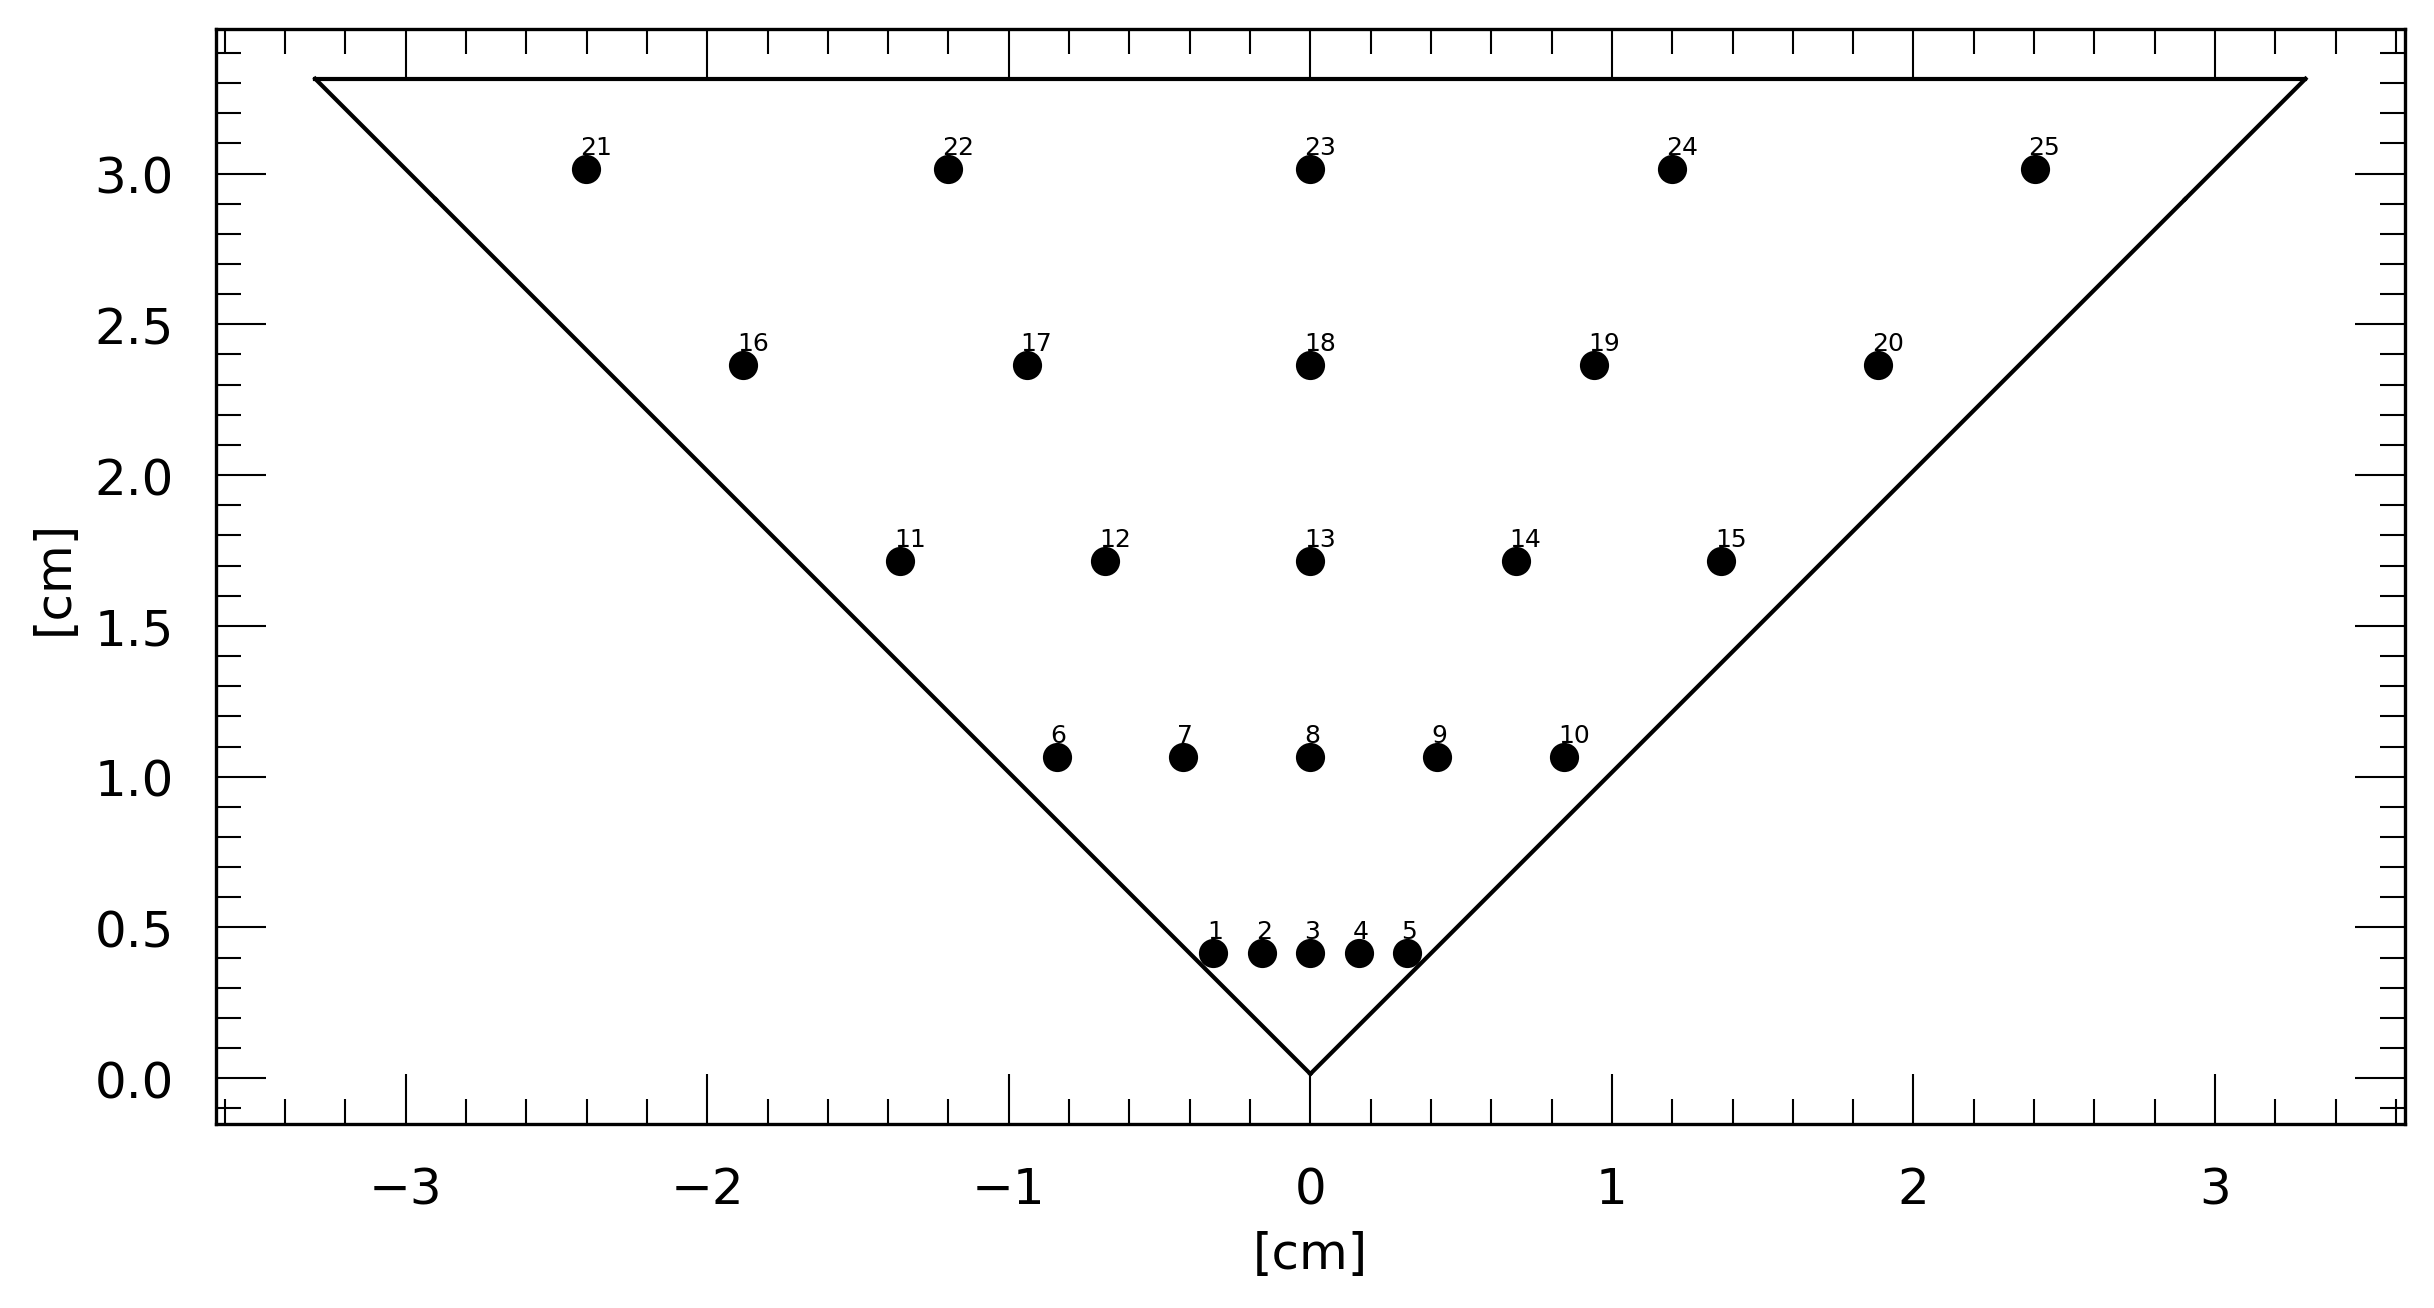

In [8]:
steps = 5
man = st.processing.Manager(world_func, out_dir=f'all_cuts/')
man.define_grid(
    vertical_range=zrange,
    horizontal_func=lambda z: (-0.8*z+0.01, -(-0.8*z+0.01)),
    steps=steps,
    visualize=True
)

## Run

In [9]:
runs = man.run(200, seed=100, visualize=False)

/home/reed/Documents/research/grimpress/crystal-geometry/scintillator_tracer/plotting.py:91: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  C = ax.pcolormesh(Y, Z, surface, **pcolorkwargs)


all_cuts/runs_20240808T151041/figures/crystal_absorbed.png
all_cuts/runs_20240808T151041/figures/optical pad_absorbed.png
all_cuts/runs_20240808T151041/figures/sipm_absorbed.png


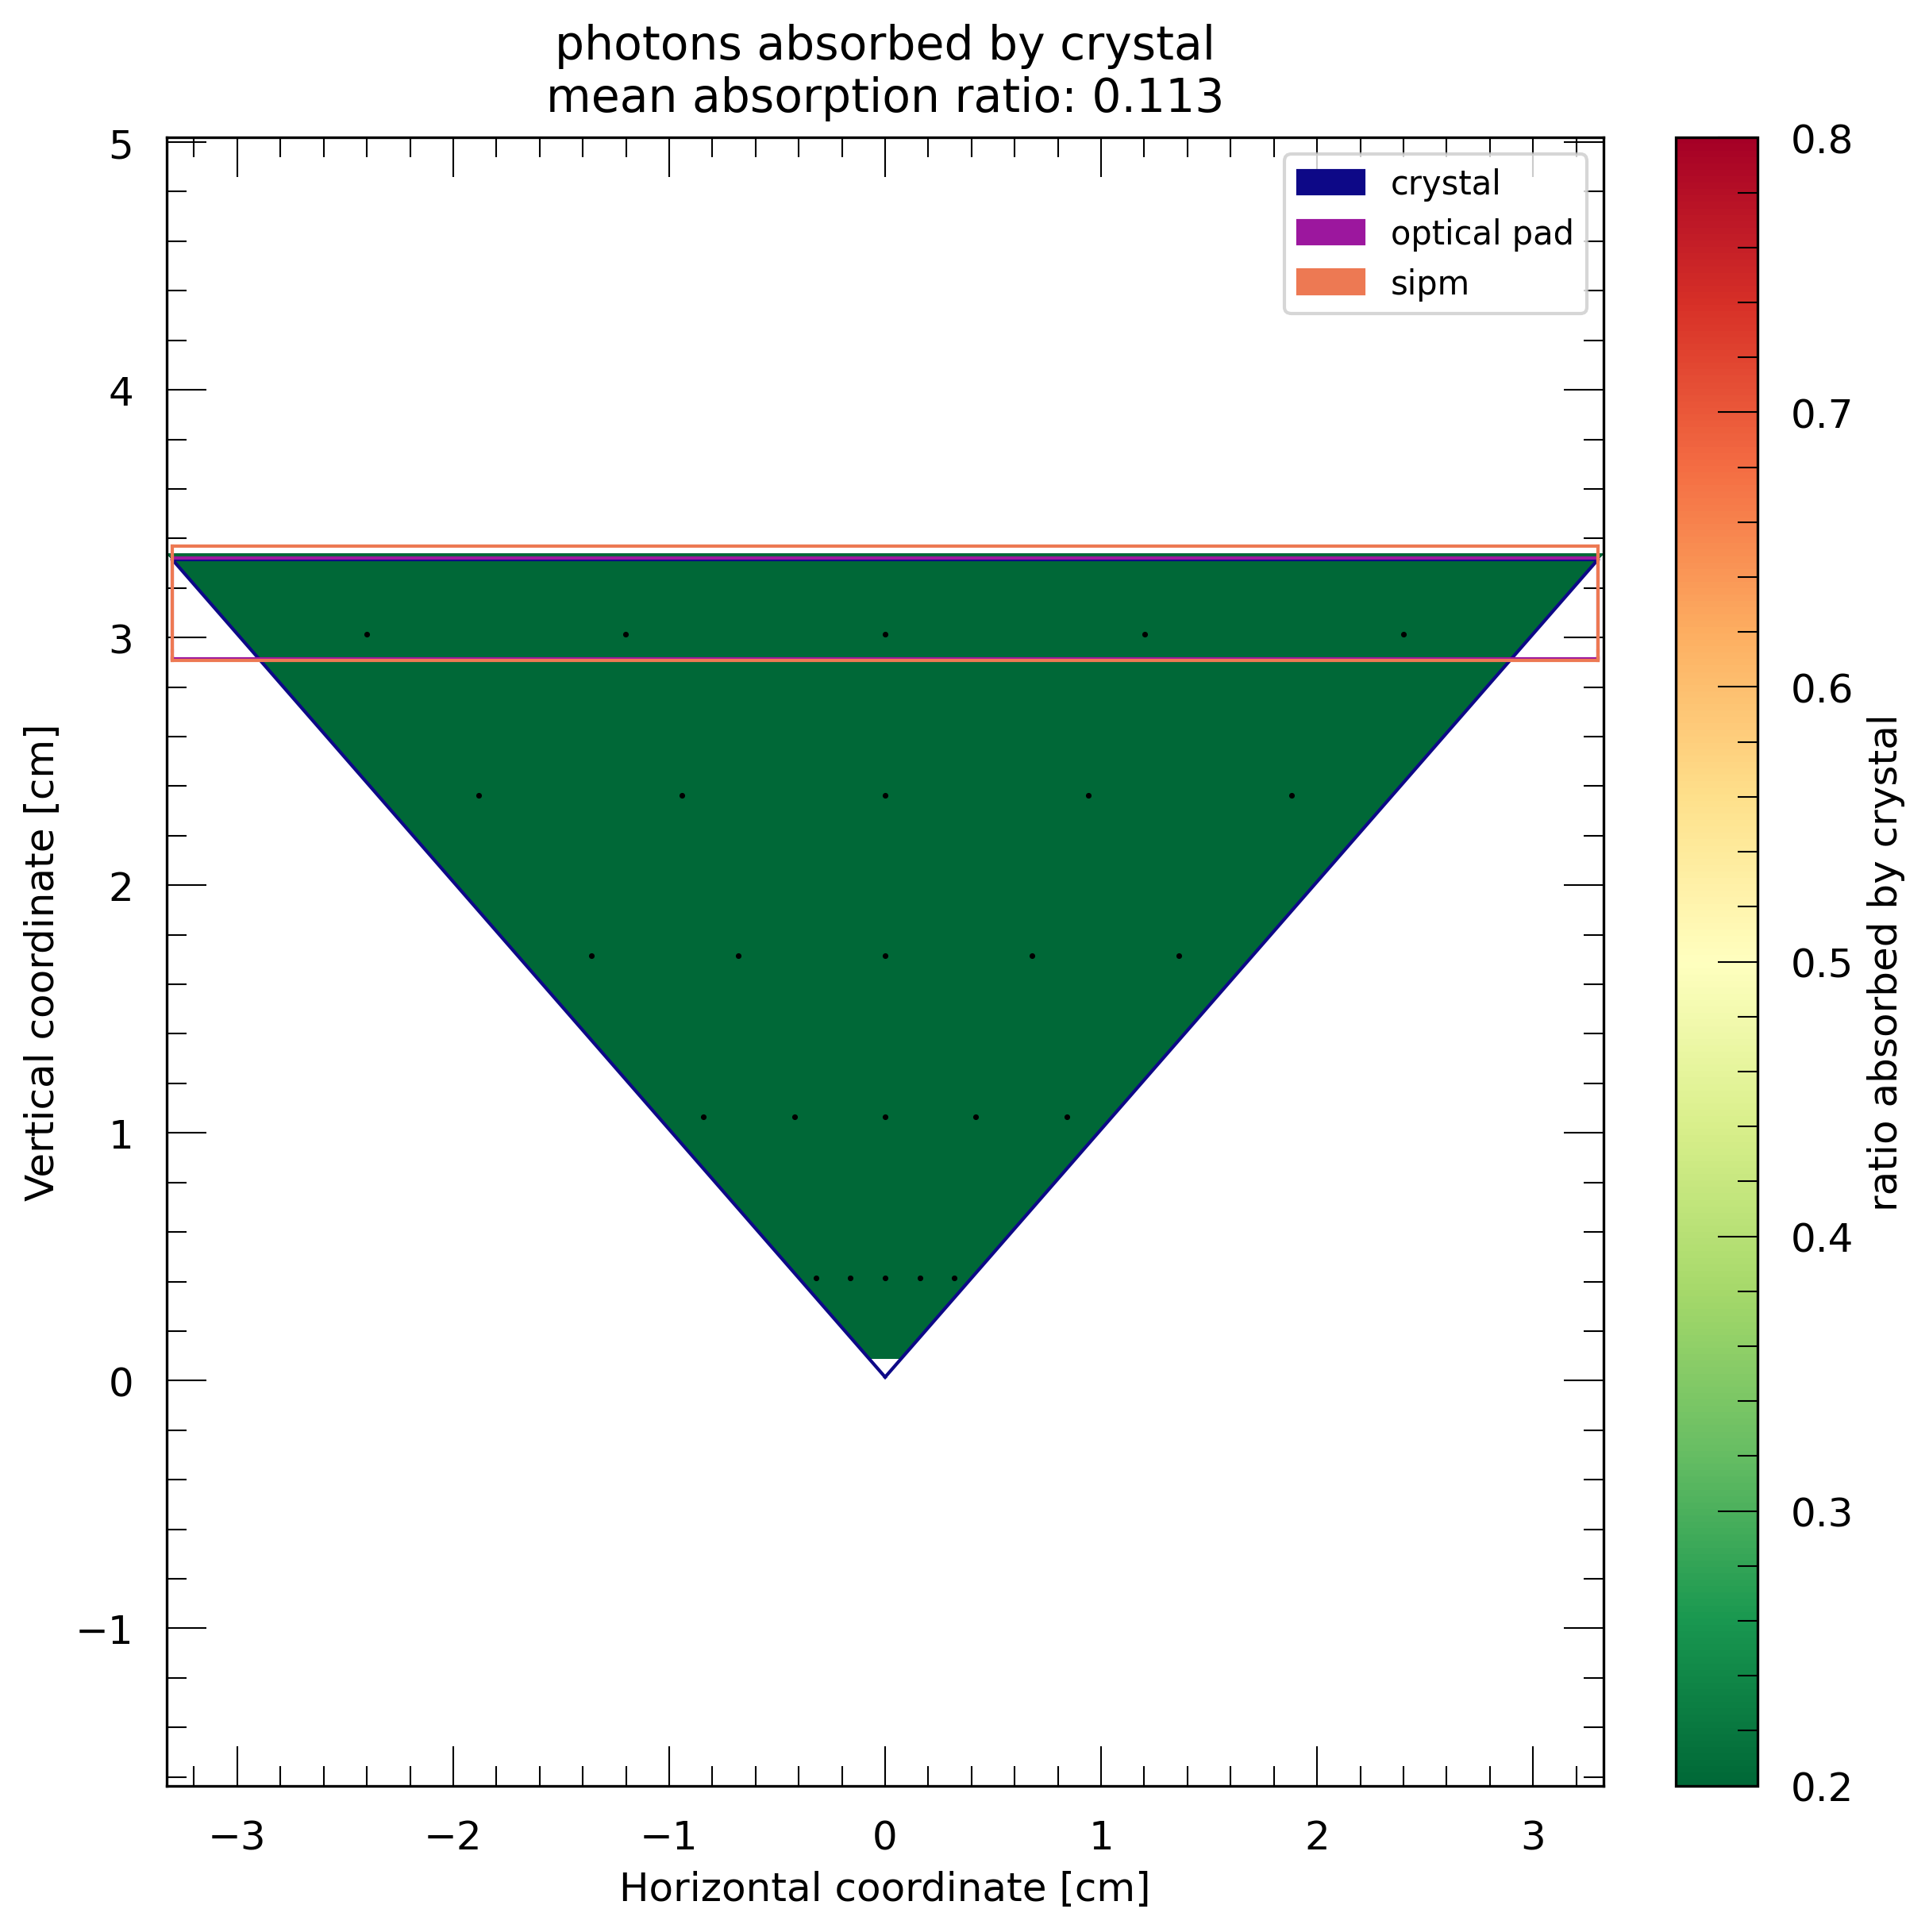

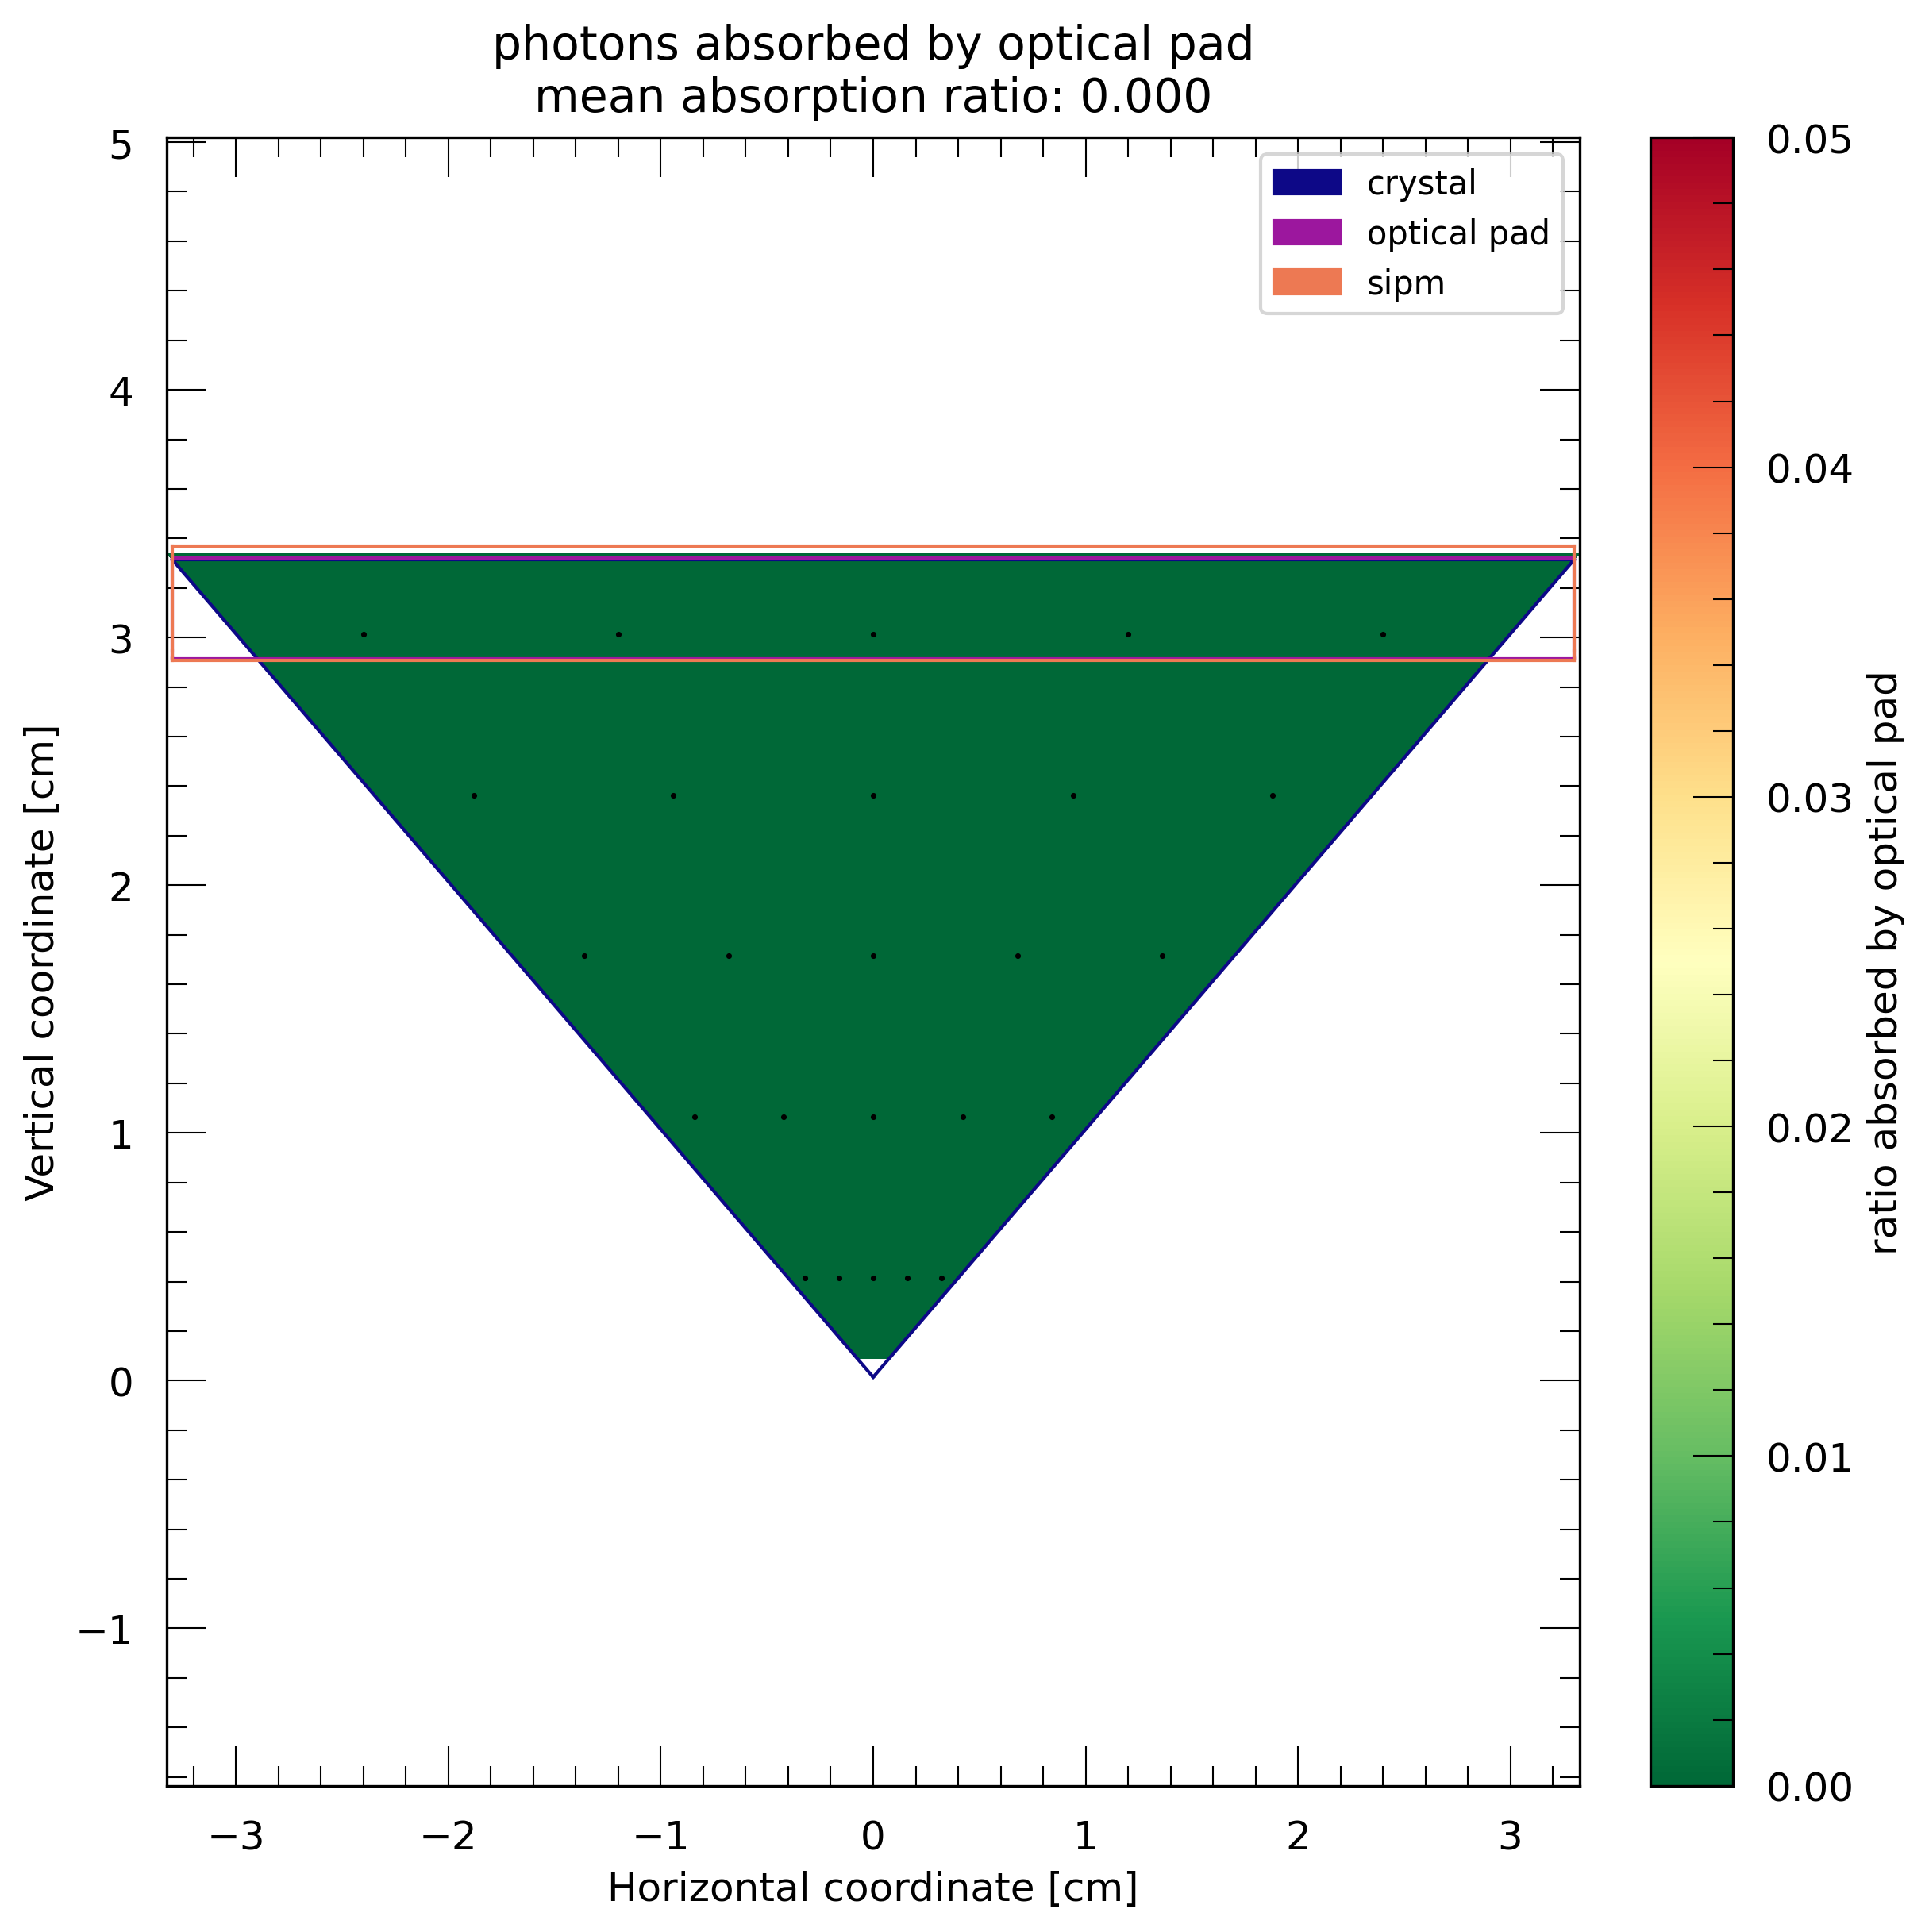

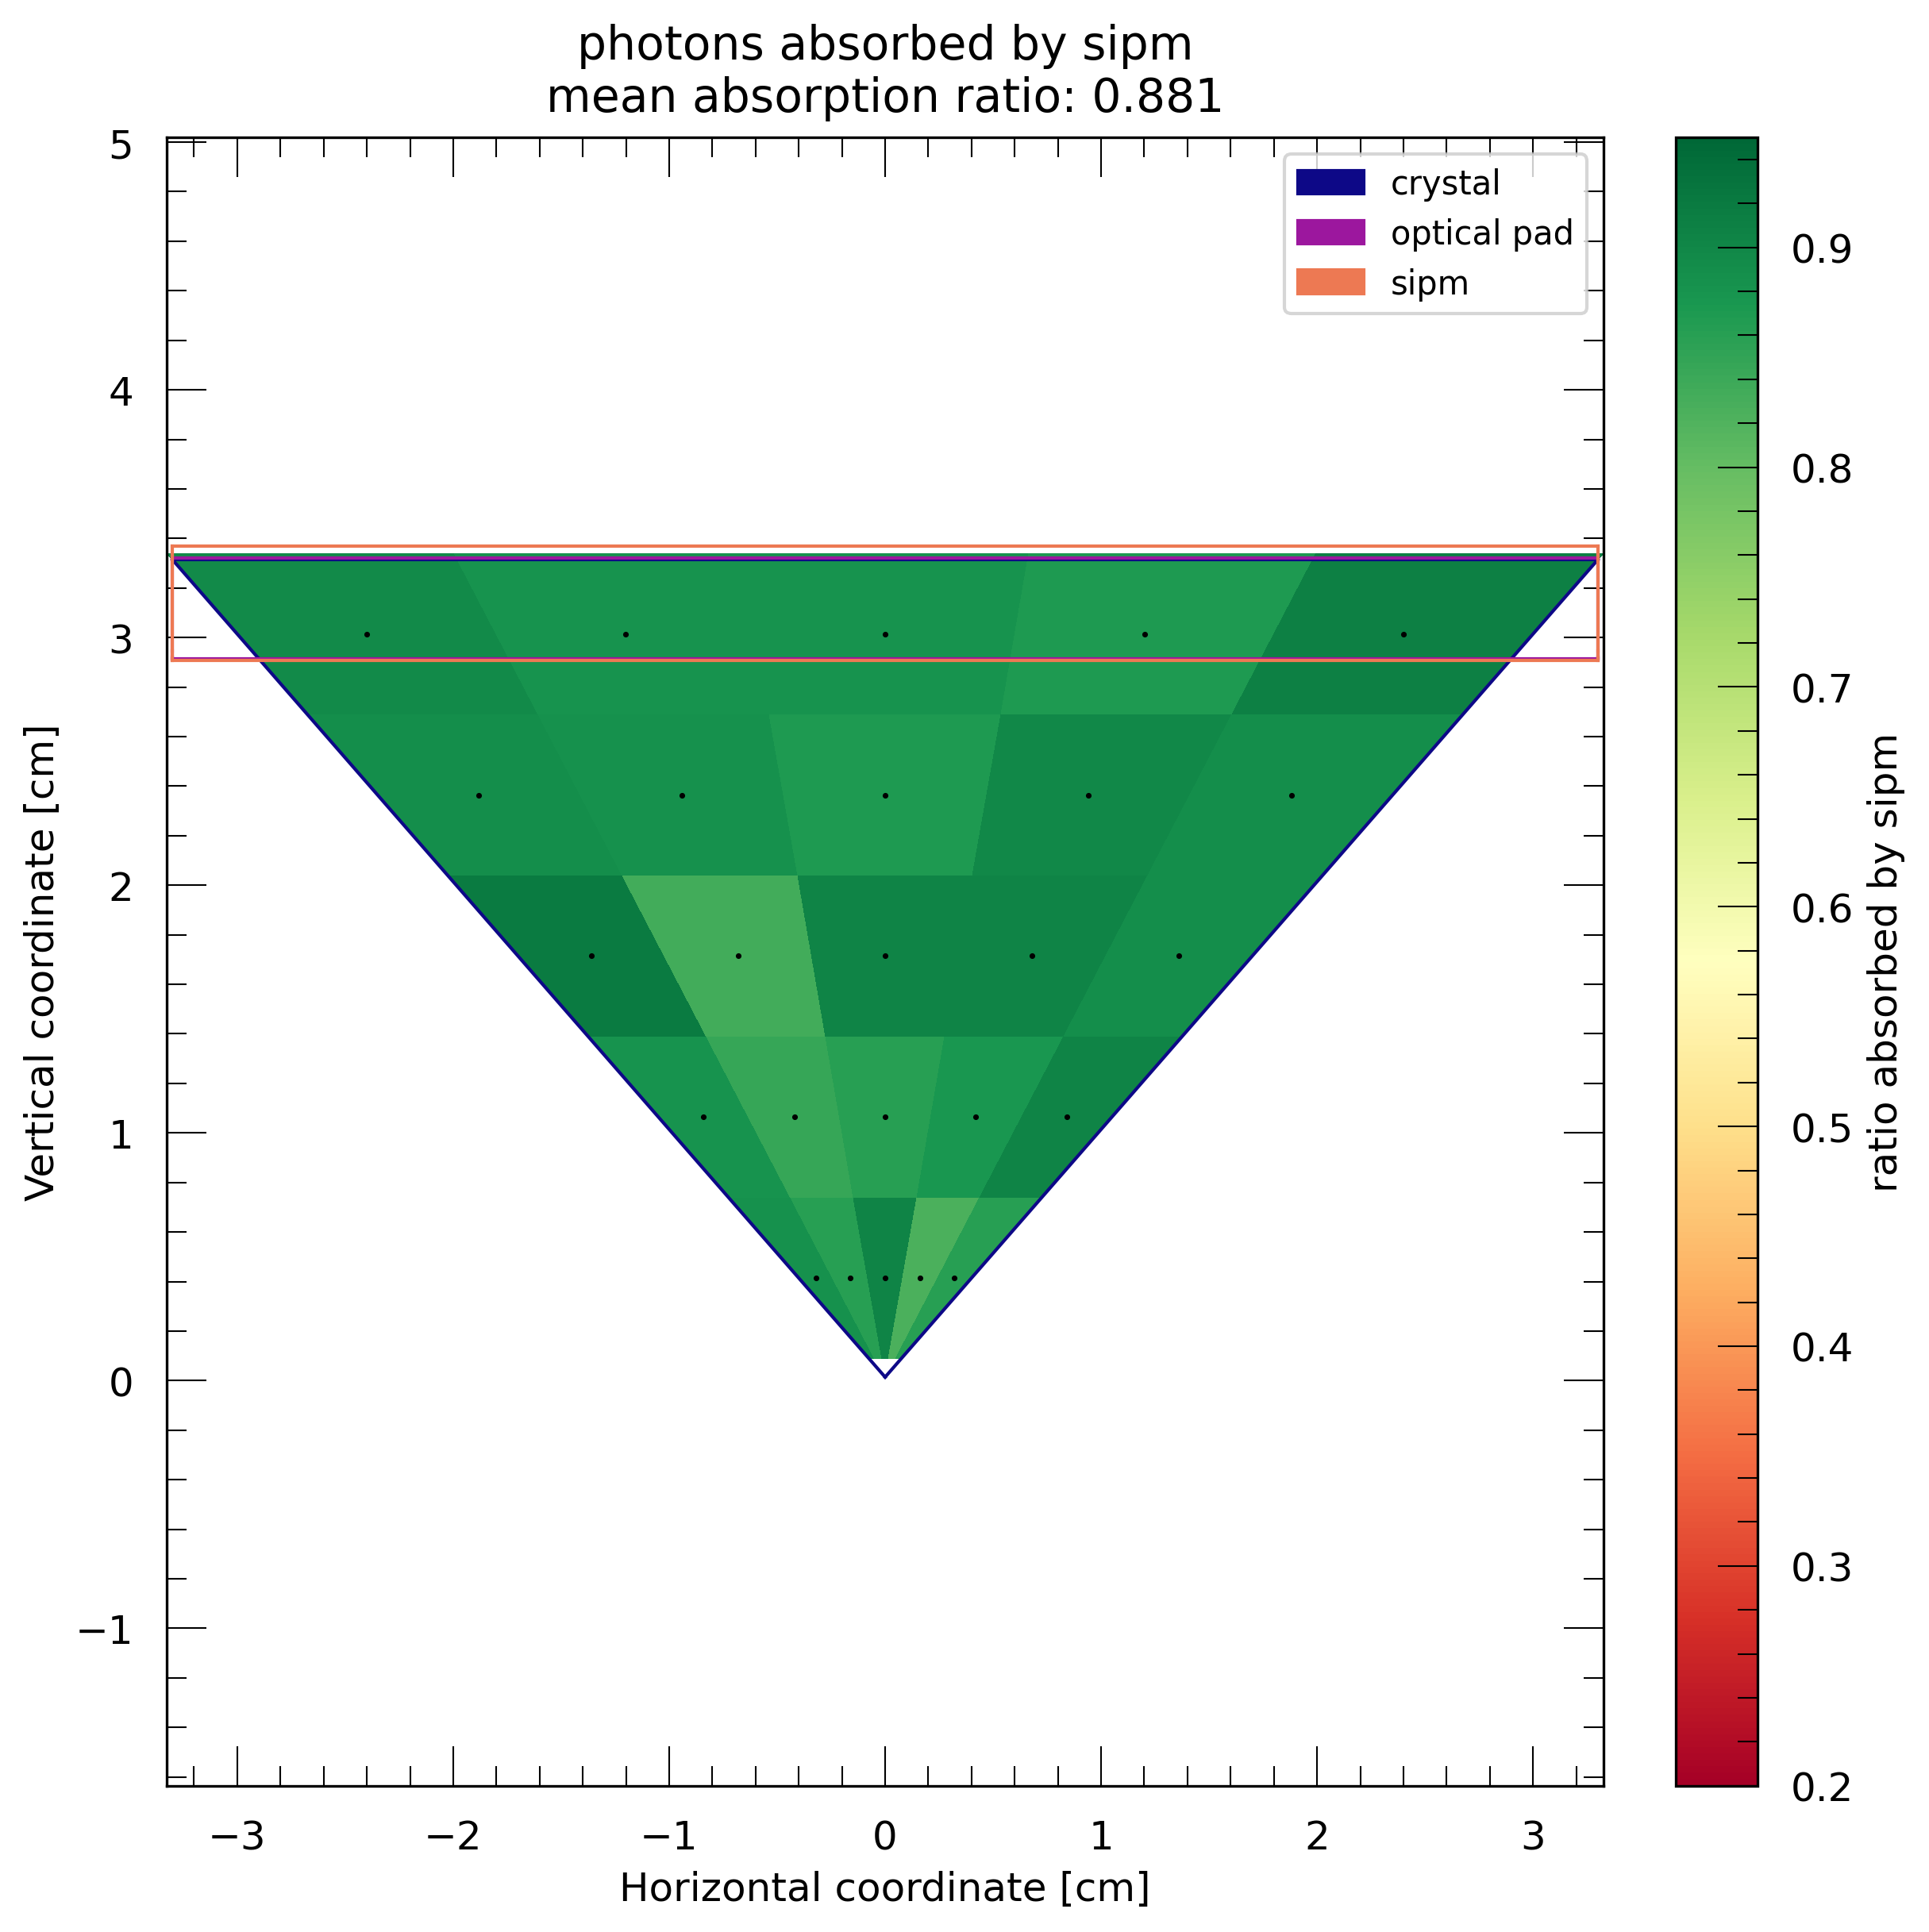

In [10]:
man.plot_all_ratios_absorbed(sipm_kwargs=dict(vmax=0.95))

## Mean free path

<AxesSubplot:title={'center':'mean path length: 6.45 cm'}, xlabel='Photon path length [cm]', ylabel='Counts'>

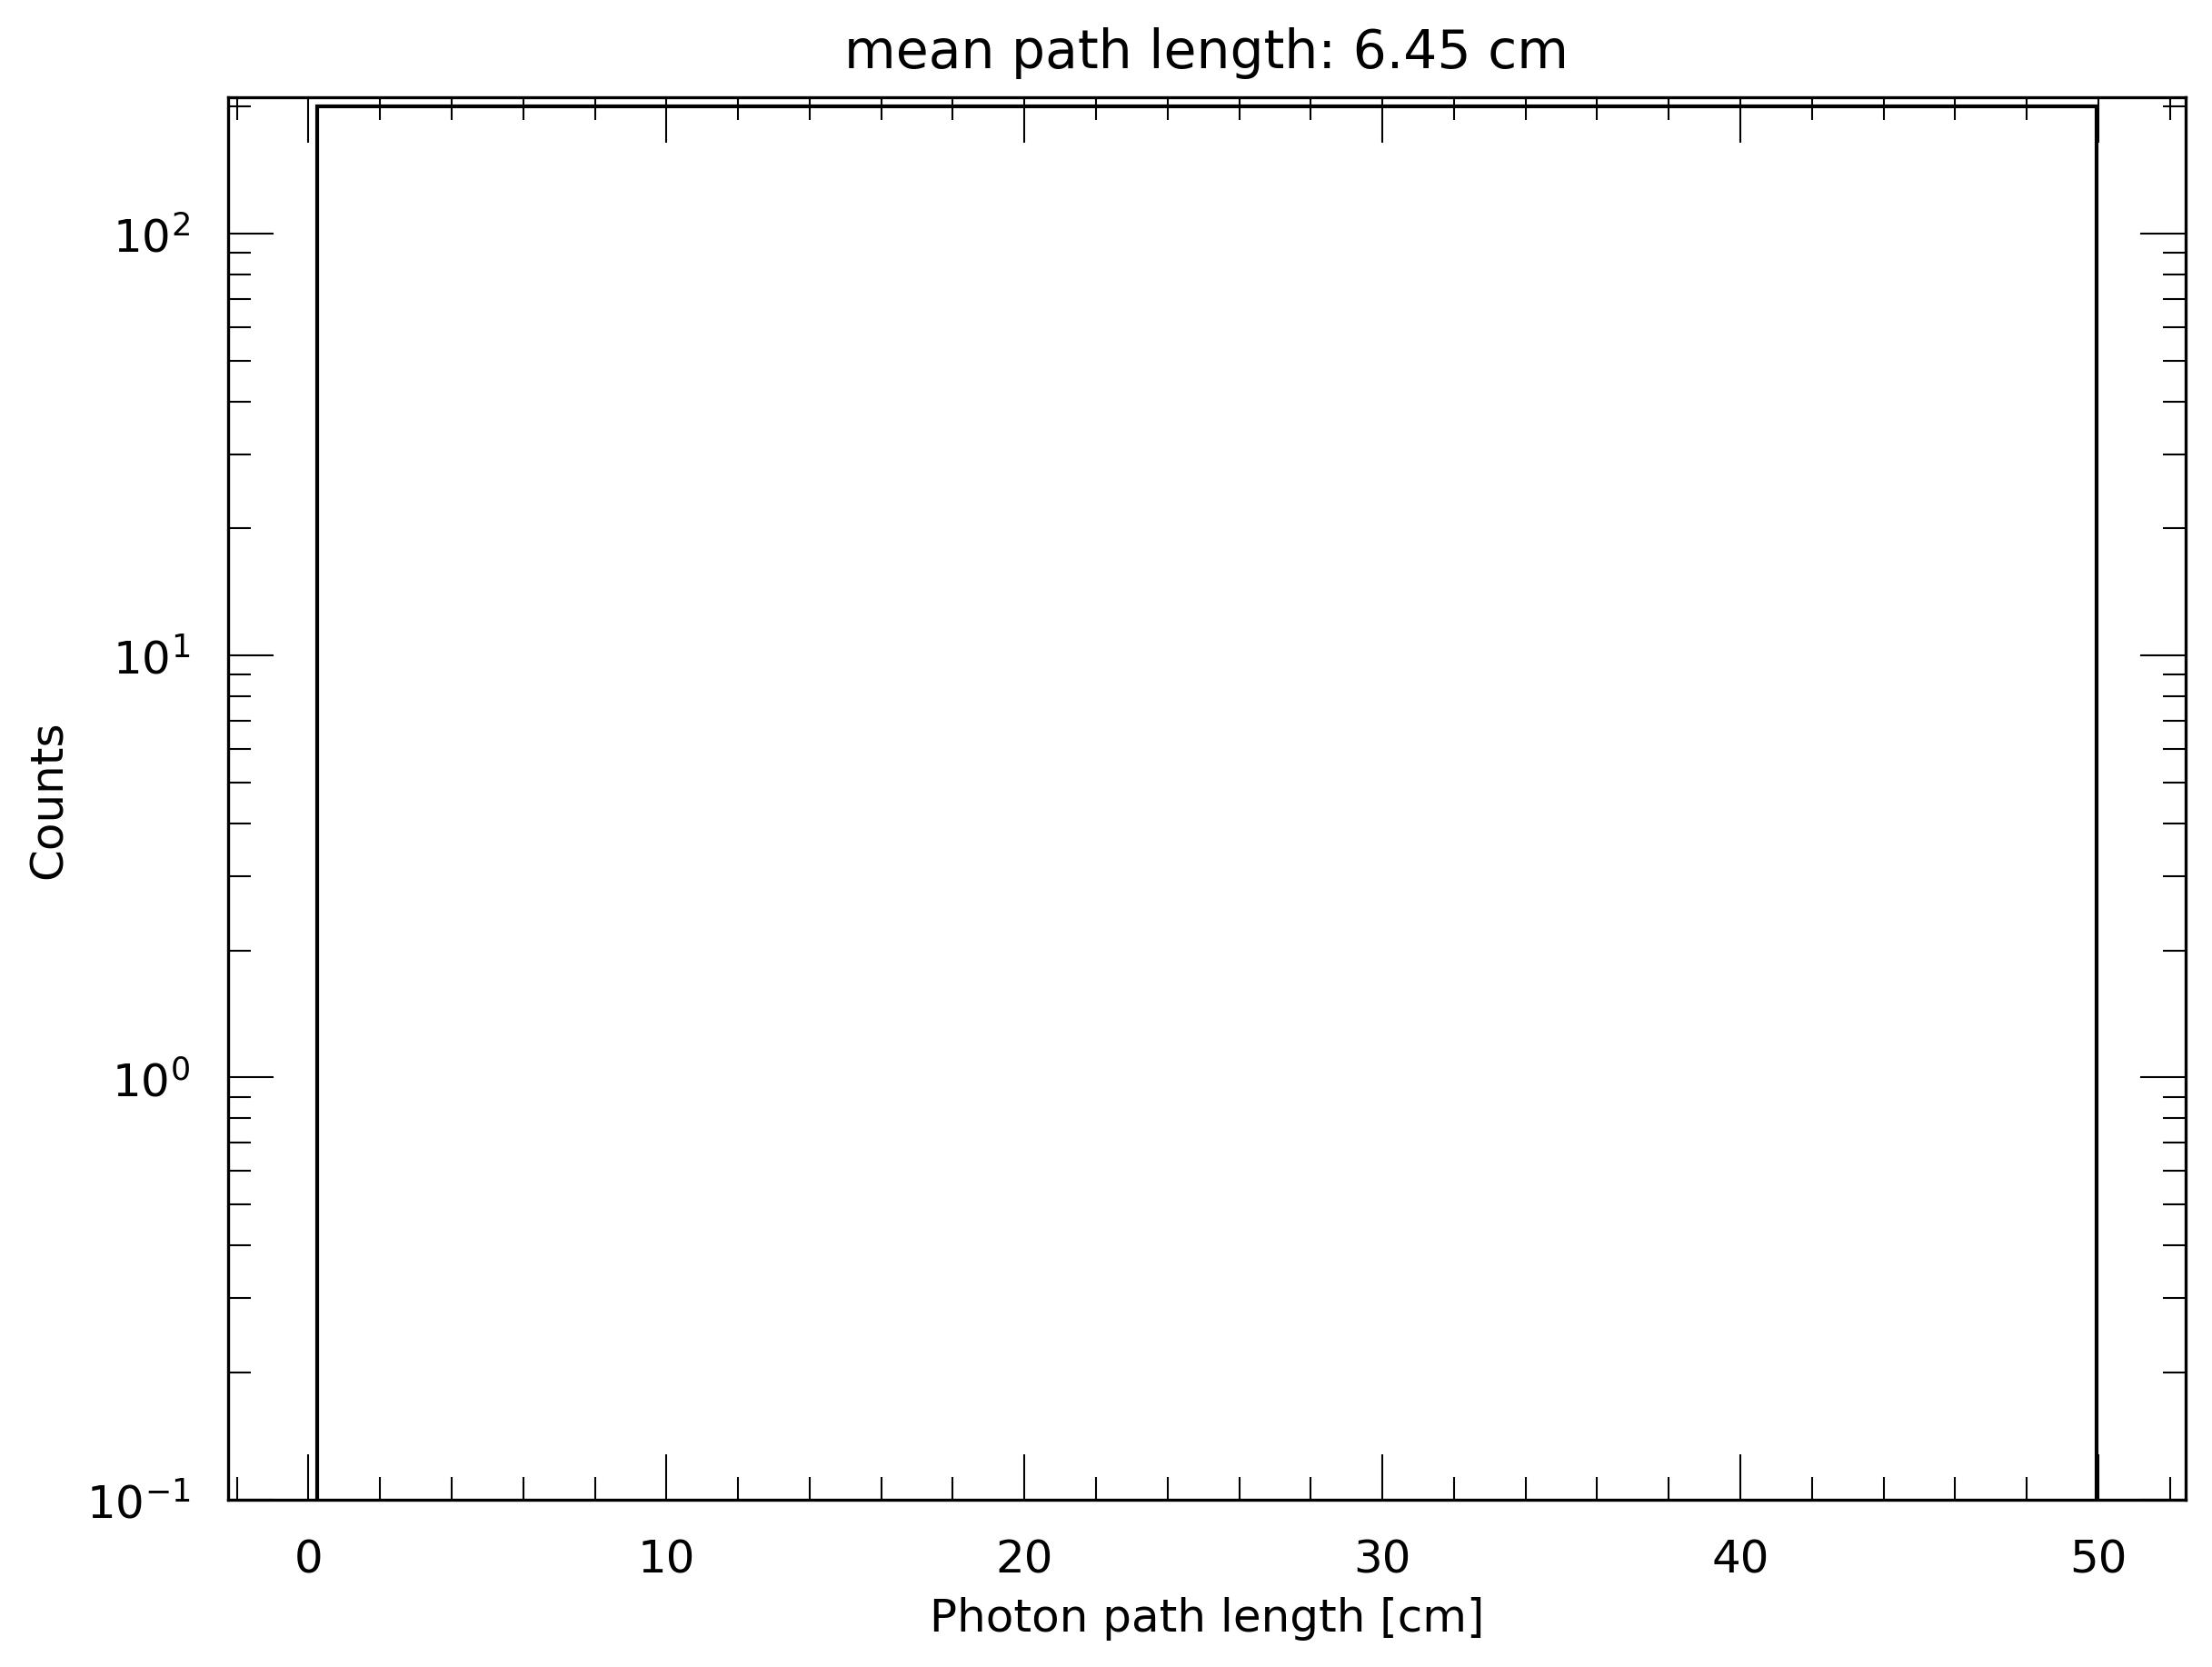

In [11]:
distances = st.processing.compute_ray_path_lengths(man.runs[0].ray_dict.all)
st.processing.histogram_distances(distances, bins=1)

run: 01
total number of optical photons: 200
	ratio absorb: 1.0
	ratio exit: 0.0
	ratio kill: 0.0
	ratio reflect: 0.0
	ratio crystal_absorbed: 0.115
	ratio optical_pad_absorbed: 0.0
	ratio sipm_absorbed: 0.885




run: 02
total number of optical photons: 200
	ratio absorb: 1.0
	ratio exit: 0.0
	ratio kill: 0.0
	ratio reflect: 0.0
	ratio crystal_absorbed: 0.14
	ratio optical_pad_absorbed: 0.0
	ratio sipm_absorbed: 0.86




run: 03
total number of optical photons: 200
	ratio absorb: 0.995
	ratio exit: 0.005
	ratio kill: 0.0
	ratio reflect: 0.0
	ratio crystal_absorbed: 0.09
	ratio optical_pad_absorbed: 0.0
	ratio sipm_absorbed: 0.905




run: 04
total number of optical photons: 200
	ratio absorb: 0.985
	ratio exit: 0.015
	ratio kill: 0.0
	ratio reflect: 0.0
	ratio crystal_absorbed: 0.16
	ratio optical_pad_absorbed: 0.0
	ratio sipm_absorbed: 0.825




run: 05
total number of optical photons: 200
	ratio absorb: 1.0
	ratio exit: 0.0
	ratio kill: 0.0
	ratio reflect: 0.0
	ratio crystal_absorbe

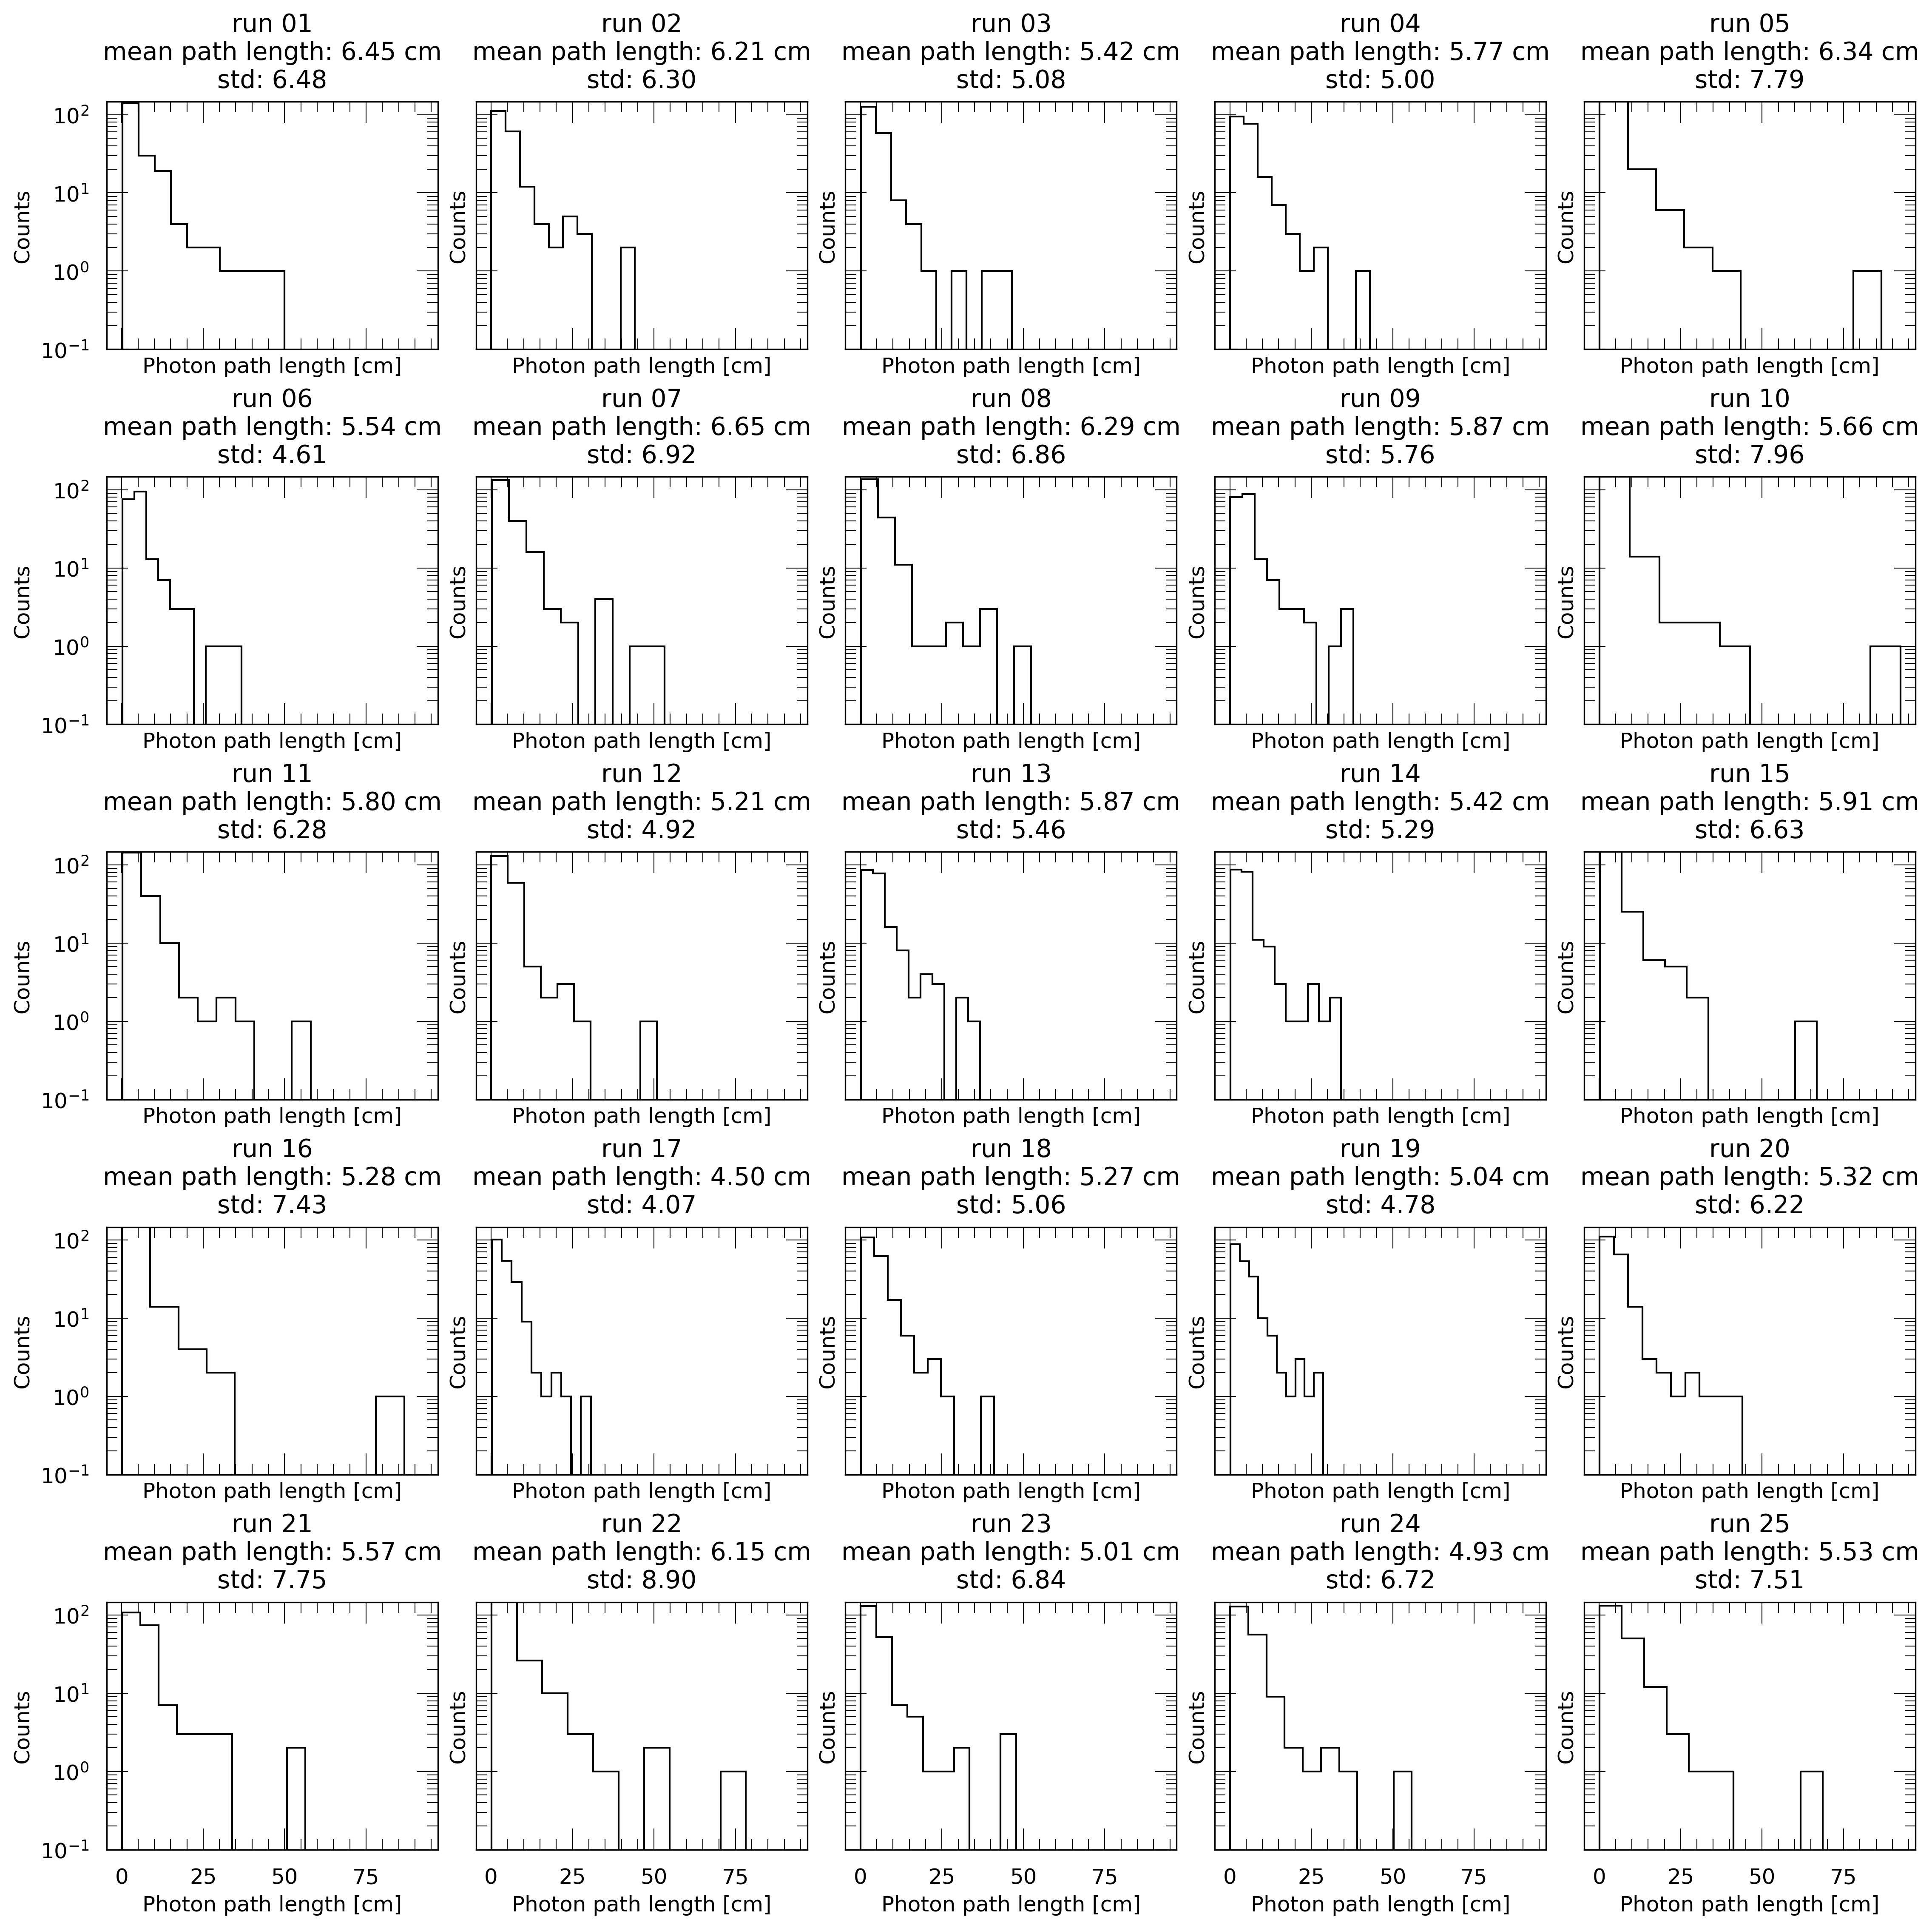

In [12]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(steps, steps, figsize=(3*steps, 3*steps), layout='constrained', sharex=True, sharey=True)
for i, run in enumerate(runs):
    row = i // steps
    col = i % steps
    ax = axs[row,col]

    events = run.ray_dict
    print('run:', run.index)
    st.processing.print_event_report(events)
    print('\n\n\n')
    distances = st.processing.compute_ray_path_lengths(events.all)
    st.processing.histogram_distances(distances, ax=ax)
    ax.set_title(f'run {run.index}\n{ax.get_title()}\nstd: {np.std(distances):0.2f}')

plt.show()